In [11]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train = pd.read_csv(train_csv)

In [3]:
class KagglePEDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, transform=None, split=0):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.transform = transform
        
        # data is divided into sets of 100,000 2D slices
        self.split = split
        
        # copy file to scratch space on the fly
        copyfile('npy-' + str(split + 1) + '.hdf5', '/scratch/npy-' + str(split + 1) + '.hdf5')
        self.filename = '/scratch/npy-' + str(split + 1) + '.hdf5'
    
    def destroy(self):
        os.remove(self.filename )

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return 100000
    
    def get_class_weights(self):
        subset = self.pedataframe[:len(self)]
        pos = subset[subset.pe_present_on_image == 1]
        neg = subset[subset.pe_present_on_image == 0]
        return 1. / torch.tensor([len(neg), len(pos)], dtype=torch.float)
    
    def get_targets(self):
        subset = self.pedataframe[:len(self)]
        return torch.tensor(subset.pe_present_on_image, dtype=torch.long)

    def __getitem__(self, idx):
        df_idx = idx + 100000 * self.split

        h5py_file = h5py.File(self.filename, "r")
        data_identifier = self.pedataframe.StudyInstanceUID[df_idx] + \
            '/' + self.pedataframe.SOPInstanceUID[df_idx]

        img = h5py_file[data_identifier][:]
        pe_present_on_image = int(self.pedataframe.pe_present_on_image[idx])
        
        #resize 512x512 -> 256x256
        img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
        
        # center crop 224
        crop_size = 224
        row = (img.shape[-2] - crop_size) // 2
        col = (img.shape[-1] - crop_size) // 2
        img = img[row : row + crop_size, col : col + crop_size]

        # unsqueeze to add channel dimension
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0)
        h5py_file.close()
        
        return self.transform(img), torch.tensor(pe_present_on_image, dtype=torch.float)

In [12]:
global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])
pe_dataset = KagglePEDataset(csv_file=train_csv, transform=transform, split=0)

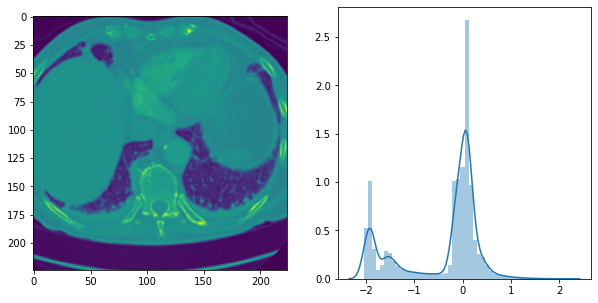

In [13]:
image, target = pe_dataset[5]
image = image.squeeze(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
sns.distplot(image.flatten(), ax=ax[1]);

In [4]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

In [5]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))
    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(loss_np)

    val_loss = sum(val_loss) / len(val_loss)
    
    return float(val_loss)

In [8]:
resnext101 = models.resnext50_32x4d(pretrained=True, progress=True)
resnext101.fc = torch.nn.Linear(resnext101.fc.in_features, 1)
resnext101.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [9]:
init_lr = 0.1
n_epochs = 40
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
gamma = 10
schedule = [10, 20, 30]

model = resnext101.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

master_train_loss = []
master_valid_loss = []
epoch = 1
best_valid_loss = 10

global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])

# Each epoch is 100,000 samples.
# Rotate between 6 training sets and 2 validation sets.
# (600,000 training samples and 200,000 validation samples)
train_set_indices = [0, 1, 2, 3, 4, 5]
valid_set_indices = [6, 7]

def get_weighted_sampler(dataset_train):
    weights = dataset_train.get_class_weights()
    targets = dataset_train.get_targets()
    sample_weights = weights[targets]
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True)
    return sampler

while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    if epoch in schedule:
        new_lr = optimizer.param_groups[0]["lr"] / gamma
        optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)
    
    # training dataset
    train_split = train_set_indices[epoch % len(train_set_indices)]
    print('Train split: ', train_split)
    dataset_train = KagglePEDataset(csv_file=train_csv, transform=transform, split=train_split)
    
    # Weighted sampler (to balance the dataset between positive and negative)
    train_sampler = get_weighted_sampler(dataset_train)

    # training loader
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, 
        sampler=train_sampler, num_workers=1)
    
    # validation dataset
    valid_split = valid_set_indices[epoch % len(valid_set_indices)]
    print('Valid split: ', valid_split)
    dataset_valid = KagglePEDataset(csv_file=train_csv, transform=transform, split=valid_split)
    
    # validation loader
    valid_sampler = get_weighted_sampler(dataset_valid)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=16, 
        sampler=valid_sampler, num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss = valid_epoch(model, train_loader)
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    with open('train_loss.pkl', 'wb') as f:
        pickle.dump(master_train_loss, f)
    with open('valid_loss.pkl', 'wb') as f:
        pickle.dump(master_valid_loss, f)
        
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'model-resnext-50-best.pth')
        best_valid_loss = valid_loss
    
    epoch += 1
    
    #clean up scratch
    dataset_train.destroy()
    dataset_valid.destroy()
        

Mon Nov 23 18:53:45 2020 Epoch: 1
Train split:  1
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.74it/s]


Mon Nov 23 19:29:22 2020 Epoch 1, lr: 0.1000000, train loss: 0.72319, valid loss: 0.69329
Mon Nov 23 19:29:33 2020 Epoch: 2
Train split:  2
Valid split:  6


100%|██████████| 6250/6250 [05:12<00:00, 19.99it/s]


Mon Nov 23 20:04:47 2020 Epoch 2, lr: 0.1000000, train loss: 0.70301, valid loss: 0.70640
Mon Nov 23 20:04:59 2020 Epoch: 3
Train split:  3
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.72it/s]


Mon Nov 23 20:40:13 2020 Epoch 3, lr: 0.1000000, train loss: 0.72360, valid loss: 0.80902
Mon Nov 23 20:40:26 2020 Epoch: 4
Train split:  4
Valid split:  6


100%|██████████| 6250/6250 [05:16<00:00, 19.73it/s]


Mon Nov 23 21:15:35 2020 Epoch 4, lr: 0.1000000, train loss: 0.69778, valid loss: 0.69825
Mon Nov 23 21:15:47 2020 Epoch: 5
Train split:  5
Valid split:  7


100%|██████████| 6250/6250 [05:12<00:00, 19.98it/s]


Mon Nov 23 21:50:31 2020 Epoch 5, lr: 0.1000000, train loss: 0.69866, valid loss: 0.71075
Mon Nov 23 21:50:44 2020 Epoch: 6
Train split:  0
Valid split:  6


100%|██████████| 6250/6250 [05:16<00:00, 19.75it/s]


Mon Nov 23 22:26:49 2020 Epoch 6, lr: 0.1000000, train loss: 0.51224, valid loss: 0.31555
Mon Nov 23 22:27:02 2020 Epoch: 7
Train split:  1
Valid split:  7


100%|██████████| 6250/6250 [05:15<00:00, 19.79it/s]


Mon Nov 23 23:04:13 2020 Epoch 7, lr: 0.1000000, train loss: 0.59591, valid loss: 0.51350
Mon Nov 23 23:04:26 2020 Epoch: 8
Train split:  2
Valid split:  6


100%|██████████| 6250/6250 [05:14<00:00, 19.89it/s]


Mon Nov 23 23:39:32 2020 Epoch 8, lr: 0.1000000, train loss: 0.54705, valid loss: 0.47318
Mon Nov 23 23:39:45 2020 Epoch: 9
Train split:  3
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.74it/s]


Tue Nov 24 00:15:14 2020 Epoch 9, lr: 0.1000000, train loss: 0.53858, valid loss: 0.49600
Tue Nov 24 00:15:27 2020 Epoch: 10
Train split:  4
Valid split:  6


100%|██████████| 6250/6250 [05:17<00:00, 19.72it/s]


Tue Nov 24 00:50:25 2020 Epoch 10, lr: 0.0100000, train loss: 0.55125, valid loss: 0.44366
Tue Nov 24 00:50:37 2020 Epoch: 11
Train split:  5
Valid split:  7


100%|██████████| 6250/6250 [05:13<00:00, 19.91it/s]


Tue Nov 24 01:26:00 2020 Epoch 11, lr: 0.0100000, train loss: 0.54292, valid loss: 0.44201
Tue Nov 24 01:26:12 2020 Epoch: 12
Train split:  0
Valid split:  6


100%|██████████| 6250/6250 [05:17<00:00, 19.69it/s]


Tue Nov 24 02:01:09 2020 Epoch 12, lr: 0.0100000, train loss: 0.18354, valid loss: 0.05828
Tue Nov 24 02:01:22 2020 Epoch: 13
Train split:  1
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.73it/s]


Tue Nov 24 02:36:28 2020 Epoch 13, lr: 0.0100000, train loss: 0.51998, valid loss: 0.40139
Tue Nov 24 02:36:41 2020 Epoch: 14
Train split:  2
Valid split:  6


100%|██████████| 6250/6250 [05:14<00:00, 19.90it/s]


Tue Nov 24 03:11:37 2020 Epoch 14, lr: 0.0100000, train loss: 0.49903, valid loss: 0.40074
Tue Nov 24 03:11:50 2020 Epoch: 15
Train split:  3
Valid split:  7


100%|██████████| 6250/6250 [05:17<00:00, 19.70it/s]


Tue Nov 24 03:47:11 2020 Epoch 15, lr: 0.0100000, train loss: 0.46145, valid loss: 0.38006
Tue Nov 24 03:47:23 2020 Epoch: 16
Train split:  4
Valid split:  6


100%|██████████| 6250/6250 [05:15<00:00, 19.78it/s]


Tue Nov 24 04:22:26 2020 Epoch 16, lr: 0.0100000, train loss: 0.46695, valid loss: 0.38045
Tue Nov 24 04:22:38 2020 Epoch: 17
Train split:  5
Valid split:  7


100%|██████████| 6250/6250 [05:12<00:00, 19.99it/s]


Tue Nov 24 04:57:21 2020 Epoch 17, lr: 0.0100000, train loss: 0.48520, valid loss: 0.39208
Tue Nov 24 04:57:34 2020 Epoch: 18
Train split:  0
Valid split:  6


100%|██████████| 6250/6250 [05:17<00:00, 19.66it/s]


Tue Nov 24 05:32:17 2020 Epoch 18, lr: 0.0100000, train loss: 0.11457, valid loss: 0.03956
Tue Nov 24 05:32:30 2020 Epoch: 19
Train split:  1
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.78it/s]


Tue Nov 24 06:07:23 2020 Epoch 19, lr: 0.0100000, train loss: 0.46403, valid loss: 0.38505
Tue Nov 24 06:07:35 2020 Epoch: 20
Train split:  2
Valid split:  6


100%|██████████| 6250/6250 [05:14<00:00, 19.89it/s]


Tue Nov 24 06:42:21 2020 Epoch 20, lr: 0.0010000, train loss: 0.59472, valid loss: 0.49806
Tue Nov 24 06:42:32 2020 Epoch: 21
Train split:  3
Valid split:  7


100%|██████████| 6250/6250 [05:16<00:00, 19.74it/s]


Tue Nov 24 07:17:24 2020 Epoch 21, lr: 0.0010000, train loss: 0.55569, valid loss: 0.47290
Tue Nov 24 07:17:36 2020 Epoch: 22
Train split:  4
Valid split:  6


100%|██████████| 6250/6250 [05:15<00:00, 19.79it/s]


Tue Nov 24 07:52:10 2020 Epoch 22, lr: 0.0010000, train loss: 0.51546, valid loss: 0.44861
Tue Nov 24 07:52:22 2020 Epoch: 23
Train split:  5
Valid split:  7


100%|██████████| 6250/6250 [05:13<00:00, 19.91it/s]


Tue Nov 24 08:27:31 2020 Epoch 23, lr: 0.0010000, train loss: 0.49746, valid loss: 0.43842
Tue Nov 24 08:27:43 2020 Epoch: 24
Train split:  0
Valid split:  6


100%|██████████| 6250/6250 [05:16<00:00, 19.73it/s]


Tue Nov 24 09:03:05 2020 Epoch 24, lr: 0.0010000, train loss: 0.13813, valid loss: 0.05145
Tue Nov 24 09:03:16 2020 Epoch: 25
Train split:  1


KeyboardInterrupt: 

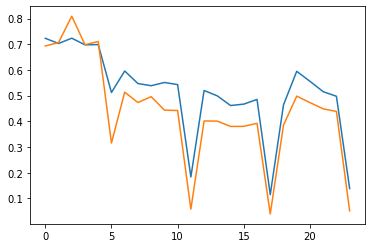

In [14]:
plt.plot(master_train_loss, label='train')
plt.plot(master_valid_loss, label='valid')

In [15]:
# Retroactive save model
epoch = 24
torch.save(model.state_dict(), 'model-resnext-50-24.pth')